In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
import torch
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from einops import rearrange 

from models.model_configs import instantiate_model
from utils.utils import get_device
from dsm import anneal_Langevin_dynamics
from models.refinenet_dilated_baseline import RefineNetDilated

In [3]:
def display(image):
    x = image.squeeze(0)
    x = rearrange(x, 'c h w -> h w c')
    x = x.numpy()
    plt.imshow(x)
    plt.show()


# device = get_device()
device = "cuda:1"


def Langevin_dynamics(x_mod, scorenet, n_steps=1000, step_lr=0.00002):
    images = []

    with torch.no_grad():
        for _ in range(n_steps):
            images.append(torch.clamp(x_mod, -1.0, 1.0).to('cpu'))
            noise = torch.randn_like(x_mod) * np.sqrt(step_lr * 2)
            # grad = scorenet(x_mod, torch.tensor([0]*x_mod.shape[0]).to(x_mod.device))
            grad = scorenet(x_mod)
            x_mod = x_mod + step_lr * grad + noise
            # print("modulus of grad components: mean {}, max {}".format(grad.abs().mean(), grad.abs().max()))

        return images

def inference(checkpoint_path: str):
    checkpoint = torch.load(checkpoint_path)
    model=instantiate_model("ddpm")
    # model = RefineNetDilated()
    model.load_state_dict(checkpoint)
    model=model.to(device)
    model.eval()

    sigma_begin = 30
    sigma_end = 0.01
    T = 100
    sigma = torch.tensor(
            np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end),
                               T))).float().to(device)

    samples = torch.rand(1, 3, 32, 32, device=device)
    # samples = torch.randn(1, 3, 32, 32, device=device)
    samples = samples * 2.0 - 1.0  # Scaling to [-1, 1] from [0, 1]
    synthetic_samples = anneal_Langevin_dynamics(samples, model, sigma, 50, 0.00002)
    # synthetic_samples = Langevin_dynamics(samples, model, n_steps=500, step_lr=0.00002)

     # Scaling to [0, 1] from [-1, 1]
    synthetic_samples = [torch.clamp(
        synthetic_sample * 0.5 + 0.5, min=0.0, max=1.0
    ) for synthetic_sample in synthetic_samples]

    print("Generated Image size:", synthetic_samples[-1].shape)

    display(synthetic_samples[-1].cpu())

/tmp/ipykernel_383707/3654176371.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
annealed Langevin dynamics sampling:   0%|    

annealed Langevin dynamics sampling: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


Generated Image size: torch.Size([1, 3, 32, 32])


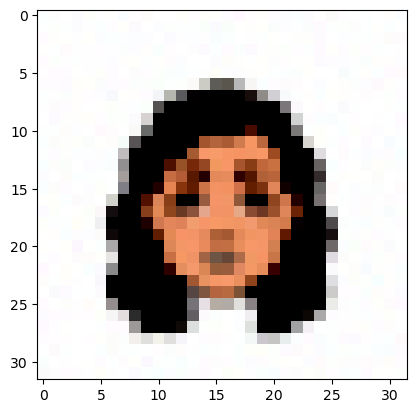

In [13]:
inference("../model_epoch_100.pth")
